# Setup

In [1]:
%%capture
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import os
import numpy as np
import pandas as pd
import scipy

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

## Set data paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Import data

In [6]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")

## Methods

### UMAP gene list

In [7]:
def plot_gene_list(adata, gene_list, layer, obs_key=None, obs_list=None, save_path=None, *arg, **kwarg):
    vmin = []
    vmax = []
    for gene in gene_list:
        if obs_key is None:
            if scipy.sparse.issparse(adata.layers[layer]):
                data = np.asarray(adata[:, gene].layers[layer].todense())
            else:
                data = adata[:, gene].layers[layer]
        else:
            if scipy.sparse.issparse(adata.layers[layer]):
                data = np.asarray(adata[adata.obs[obs_key] == obs_list[0], gene].layers[layer].todense())
            else:
                data = adata[adata.obs[obs_key] == obs_list[0], gene].layers[layer]
        vmin.append(np.quantile(data, 0.01))
        vmax.append(np.quantile(data, 0.99))
    
    if save_path is not None:
        sc.settings.figdir = save_path.rsplit("/", 1)[0]
        file = save_path.rsplit("/", 1)[1]
    else:
        file=None
    if obs_key is None:
        sc.pl.umap(
            adata,
            color=gene_list,
            layer=layer,
            vmin=vmin,
            vmax=vmax,
            save=file,
            *arg, **kwarg
        )
    else:
        for obs in obs_list:
            sc.pl.umap(
                adata[adata.obs[obs_key] == obs],
                color=gene_list,
                layer=layer,
                vmin=vmin,
                vmax=vmax,
                save=file,
                *arg, **kwarg
            )

### heatmap gene list

In [8]:
def gene_list_lfc_across_clusters(
    adata, gene_list, genotype_list, cell_type_list=None, save_path=None, genotype_key="genotype",
    layer="scVI_normalized", cell_type_key="cell_type", cbar_args=[1, 0.5, 0.01, 0.5], *args, **kwargs
):
    data = adata[adata.obs[genotype_key] == genotype_list[0], gene_list]
    
    if scipy.sparse.issparse(data.layers[layer]):
        expression = data.layers[layer].todense()
    else:
        expression = data.layers[layer]
    expression = pd.DataFrame(
        expression,
        index=data.obs.index,
        columns=data.var_names
    )
    # control_expression = control_expression[control_expression > 0.05]
    expression["cell_type"] = data.obs[cell_type_key]
    expression = expression.groupby("cell_type").mean()
    if cell_type_list is not None:
        expression = expression[expression.index.isin(cell_type_list)]
        expression = expression.reindex(cell_type_list)
    
    if cell_type_list is not None:
        expression = expression[expression.index.isin(cell_type_list)]
    
    cg = sns.clustermap(
        expression,
        *args, **kwargs,
    )
    cg.ax_cbar.set_position(cbar_args)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_ylabel("")
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Plots

## 1G

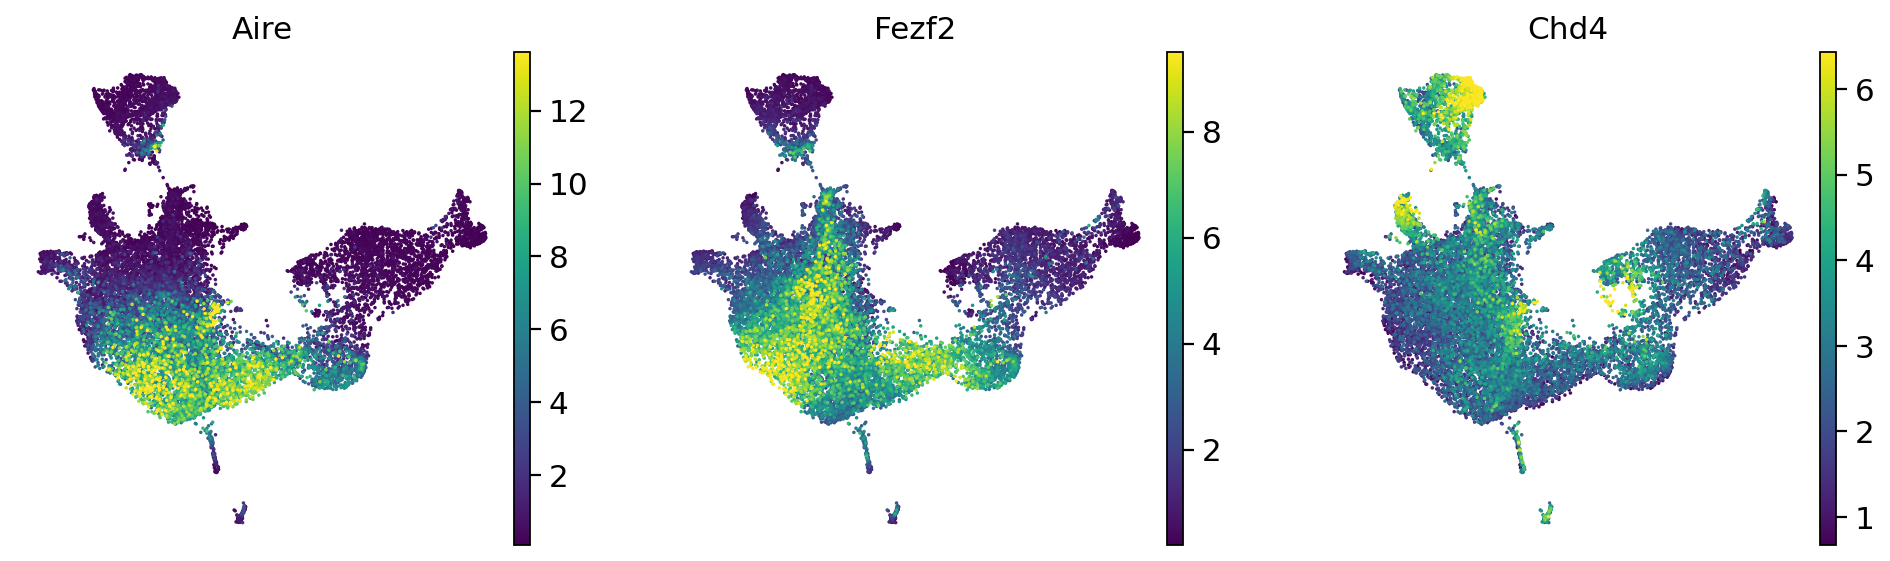

In [9]:
plot_gene_list(
    adata[adata.obs.genotype=="WT"],
    gene_list=["Aire", "Fezf2", "Chd4"],
    layer="scVI_normalized",
    save_path="../../analysis/Paper figs/1 (fezf2KO)/_1G_feature_plots.pdf",
    s=10
)

### S2B

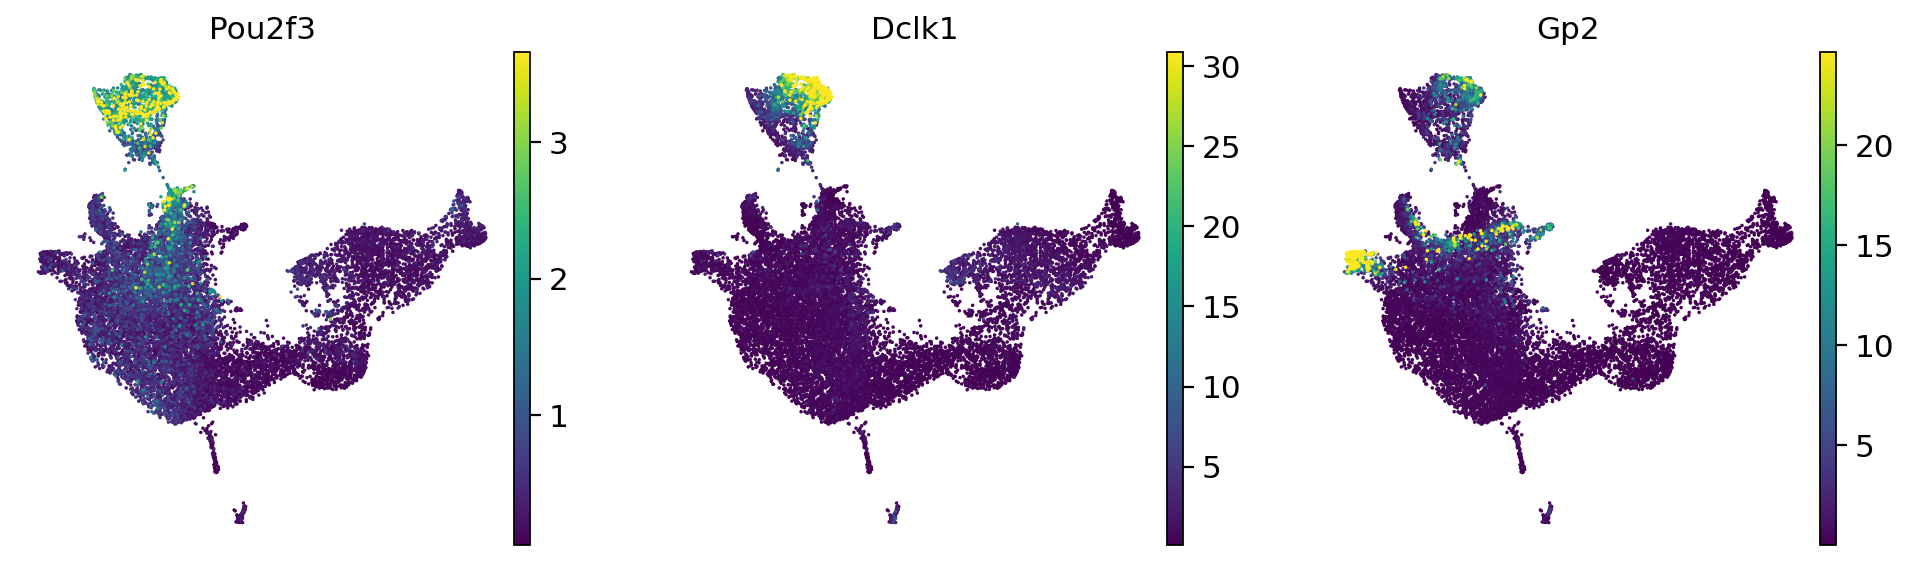

In [13]:
plot_gene_list(
    adata[adata.obs.genotype=="WT"],
    gene_list=["Pou2f3", "Dclk1", "Gp2"],
    layer="scVI_normalized",
    save_path="../../analysis/Paper figs/S2 (Fezf2 KO)/_S2B_WT_feature_plots.pdf",
    s=10
)

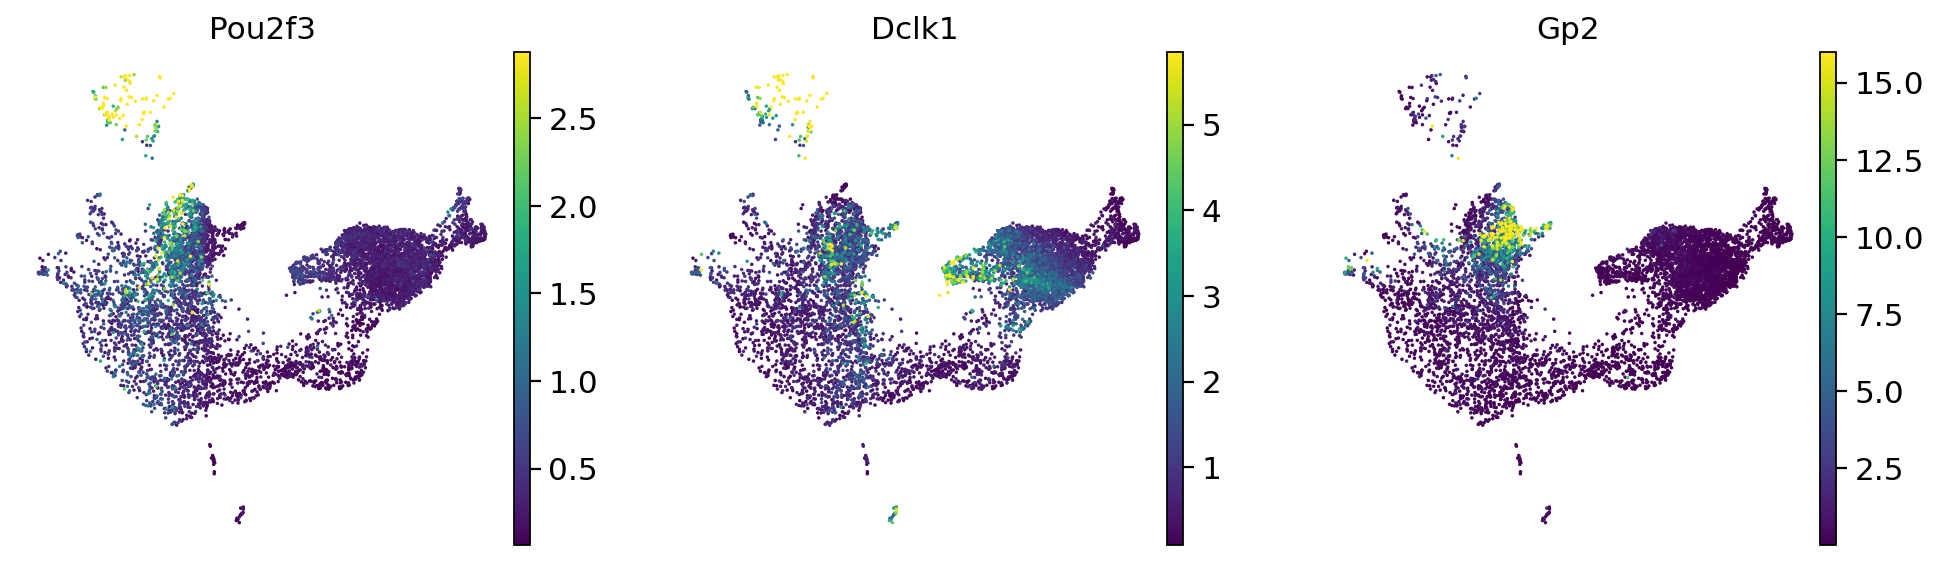

In [14]:
plot_gene_list(
    adata[adata.obs.genotype=="Fezf2_KO"],
    gene_list=["Pou2f3", "Dclk1", "Gp2"],
    layer="scVI_normalized",
    save_path="../../analysis/Paper figs/S2 (Fezf2 KO)/_S2B_Fezf2_KO_feature_plots.pdf",
    s=10
)